In [1]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.sparse import kron, identity, csr_matrix
from scipy.sparse.linalg import eigsh, eigs
from qutip import Qobj, ptrace
from tqdm import tqdm

In [2]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_y():
    """Pauli Y matrix."""
    return np.array([[0, -1j], [1j, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

def heisenberg_xxx(N, J, pbc=True):
    """
    Constructs the Hamiltonian for the Heisenberg XXX model.
    
    Parameters:
        N (int): Number of spins.
        J (float): Interaction strength.
        pbc (bool): Whether to use periodic boundary conditions.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    Y = csr_matrix(pauli_y())
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.complex128)
    
    # Interaction term: J * (sigma_i^x * sigma_{i+1}^x + sigma_i^y * sigma_{i+1}^y + sigma_i^z * sigma_{i+1}^z)
    for i in range(N - 1 + pbc):  # Adjust range for PBC
        term_x = 1
        term_y = 1
        term_z = 1
        for j in range(N):
            if j == i % N:
                term_x = kron(term_x, X, format="csr")
                term_y = kron(term_y, Y, format="csr")
                term_z = kron(term_z, Z, format="csr")
            elif j == (i + 1) % N:
                term_x = kron(term_x, X, format="csr")
                term_y = kron(term_y, Y, format="csr")
                term_z = kron(term_z, Z, format="csr")
            else:
                term_x = kron(term_x, I, format="csr")
                term_y = kron(term_y, I, format="csr")
                term_z = kron(term_z, I, format="csr")
        
        H += J * (term_x + term_y + term_z)
    
    return H

In [3]:
# Example usage
N = 4  # Number of spins
J = 1.0  # Interaction strength

# Hamiltonian with periodic boundary conditions
H_pbc = heisenberg_xxx(N, J, pbc=True)
print("Hamiltonian with PBC shape:", H_pbc.shape)
print("Non-zero elements in H with PBC:", H_pbc.nnz)
print("Hamiltonian matrix with PBC:\n", H_pbc.toarray())

# Hamiltonian with open boundary conditions
H_obc = heisenberg_xxx(N, J, pbc=False)
print("Hamiltonian with OBC shape:", H_obc.shape)
print("Non-zero elements in H with OBC:", H_obc.nnz)
print("Hamiltonian matrix with OBC:\n", H_obc.toarray())

Hamiltonian with PBC shape: (16, 16)
Non-zero elements in H with PBC: 36
Hamiltonian matrix with PBC:
 [[ 4.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  2.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j -4.+0.j  2.+0.j  0.+0.j  0.+0.j
   2.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  2.+0.j  0.+0.j

In [4]:
# 3 spins out of 12

N = 12  # Number of spins
J = 1.0  # Interaction strength
h = 1.0  # Transverse field strength

# Assuming transverse_field_ising is defined and returns a sparse Hermitian matrix
H = heisenberg_xxx(N, J, pbc = True)

In [5]:
# All eigenvalues of H

# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

min_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out 9 qubits (keep 3 qubits)
    keep_qubits = [0, 1, 2]  # Indices of qubits to keep
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced)
    min_eigenvalues.append(min_eigenvalue)

100%|██████████| 4096/4096 [20:17<00:00,  3.37it/s] 


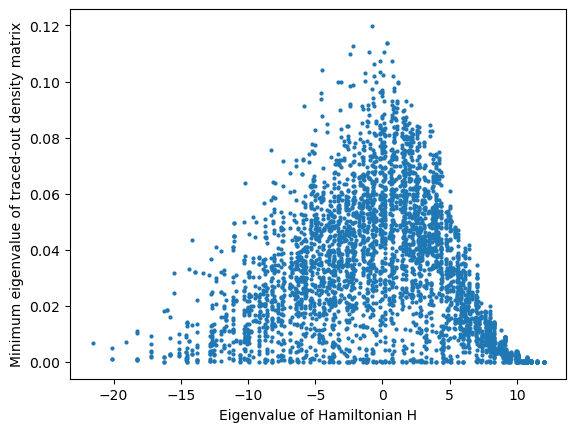

In [6]:
# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.plot(eigenvalues, min_eigenvalues, 'o', markersize=2)
plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel('Minimum eigenvalue of traced-out density matrix')
#plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()